# Ressaut Hydraulique circulaire avec *jump detection* et *jump correction* pour tous solvers.

Noé DANIEL & Richard PATEAU

In [64]:
import numpy as np
import matplotlib.pyplot as plt

Paramètres physiques

In [ ]:
g = 9.81
r_min = 0.01
r_max = 0.3
Nr    = 200
dr    = (r_max - r_min)/Nr
r     = np.linspace(r_min + 0.5*dr, r_max - 0.5*dr, Nr)

Initial

In [65]:
h_init = 0.01 * np.ones(Nr)
h_init[0] = 0.02   # un peu plus d'eau près du centre
u_init = np.zeros(Nr)
u_init[0] = 1.0

In [66]:
U_left = np.array([h_init[0], h_init[0]*u_init[0]])

In [67]:
h_threshold = 1e-5  # seuil pour éviter les divisions par zéro

In [ ]:
dt      = 3e-4
t_max   = 5.0
epsilon = 1e-9  # convergence

In [69]:
def compute_flux(U):

    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]
    
    F = np.zeros_like(U)
    F[0,:] = h*u
    F[1,:] = h*u**2 + 0.5*g*h**2
    return F

def source_term(U):

    h  = U[0,:]
    hu = U[1,:]
    u  = np.zeros_like(h)
    mask = (h>1e-10)
    u[mask] = hu[mask]/h[mask]
    
    S = np.zeros_like(U)
    S[0,:] = - (h*u)/r
    S[1,:] = - (h*u**2 + 0.5*g*h**2)/r
    return S

Flux de Rusanov

In [71]:
def flux_rusanov(U_L, U_R):

    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    hL, huL = U_L
    hR, huR = U_R
    
    uL = huL/(hL+1e-10)
    uR = huR/(hR+1e-10)
    cL = np.sqrt(g*hL)
    cR = np.sqrt(g*hR)
    
    smax = max(abs(uL)+cL, abs(uR)+cR)
    return 0.5*(F_L + F_R) - 0.5*smax*(U_R - U_L)

In [72]:
def flux_roe(U_L, U_R):

    F_L = compute_flux(U_L.reshape(2,1))[:,0]
    F_R = compute_flux(U_R.reshape(2,1))[:,0]
    hL, huL = U_L
    hR, huR = U_R
    
    uL = huL/(hL+1e-10)
    uR = huR/(hR+1e-10)
    
    # moyenne Roe
    sqrt_hL = np.sqrt(hL+1e-10)
    sqrt_hR = np.sqrt(hR+1e-10)
    h_tilde = sqrt_hL*sqrt_hR
    
    u_tilde = (sqrt_hL*uL + sqrt_hR*uR)/(sqrt_hL + sqrt_hR + 1e-10)
    c_tilde = np.sqrt(g*h_tilde)
    
    dU = U_R - U_L
    smax = abs(u_tilde) + c_tilde
    return 0.5*(F_L + F_R) - 0.5*smax*dU

In [ ]:
def flux_hllc(U_L, U_R):
    """
    Référence : Toro, Bathe, etc.
    """

    hL, huL = U_L
    hR, huR = U_R
    
    uL = huL/(hL+1e-10)
    uR = huR/(hR+1e-10)
    
    cL = np.sqrt(g*hL)
    cR = np.sqrt(g*hR)
    
    #Vitesses ondes gauche/droite
    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)
    
    #Flux gauche/droit
    FL = compute_flux(U_L.reshape(2,1))[:,0]
    FR = compute_flux(U_R.reshape(2,1))[:,0]
    
    if SL >= 0:
        # Tout va vers la droite
        return FL
    elif SR <= 0:
        # Tout va vers la gauche
        return FR
    else:
        # Calcul de S_star
        # pressions "p" ~ 0.5*g*h^2
        pL = 0.5*g*hL**2
        pR = 0.5*g*hR**2
        
        # h ~ "densité"? => cfr. Toro eq.
        # S_star = ( (SR - uR)*hR*uR - (SL-uL)*hL*uL + (pL - pR ) ) 
        #         / [ hR (SR - uR) - hL (SL - uL) ]
        
        num = ( (SR - uR)*hR*uR - (SL - uL)*hL*uL + (pL - pR) )
        den = ( hR*(SR - uR) - hL*(SL - uL) )
        if abs(den) < 1e-14:
            S_star = 0.5*(uL + uR)  # fallback
        else:
            S_star = num/(den + 1e-14)
        
        # h*_L et h*_R
        # h*_L = hL * (SL - uL)/(SL - S_star)
        # idem pour R
        if (SL - S_star)==0:
            h_star_L = hL
        else:
            h_star_L = hL*(SL - uL)/( (SL - S_star) + 1e-14 )
        
        if (SR - S_star)==0:
            h_star_R = hR
        else:
            h_star_R = hR*(SR - uR)/( (SR - S_star) + 1e-14 )
        
        # F*_L et F*_R
        # Q*_L = ( h*_L, h*_L * S_star )
        # F*_L = FL + SL( Q*_L - QL )
        QL = np.array([hL, huL])
        QR = np.array([hR, huR])
        
        Qstar_L = np.array([ h_star_L, h_star_L*S_star ])
        Fstar_L = FL + SL*( Qstar_L - QL )
        
        Qstar_R = np.array([ h_star_R, h_star_R*S_star ])
        Fstar_R = FR + SR*( Qstar_R - QR )
        
        # Choix final
        if S_star >= 0:
            # 0 > SL => star region = gauche
            return Fstar_L
        else:
            return Fstar_R

In [73]:
def mac_cormack_step(U, dt):

    Nr_local = U.shape[1]
    
    # (prédicteur) 
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        Fnum[:, j] = flux_rusanov(U[:, j-1], U[:, j])
    # BC
    Fnum[:, 0] = flux_rusanov(U_left, U[:, 0])
    Fnum[:, Nr_local] = flux_rusanov(U[:, Nr_local-1], U[:, Nr_local-1])
    
    S_loc = source_term(U)
    U_pred = U.copy()
    for j in range(Nr_local):
        U_pred[:, j] = ( U[:, j]
                         - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                         + dt*S_loc[:, j] )
    
    # (correcteur)
    Fnum2 = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        Fnum2[:, j] = flux_rusanov(U_pred[:, j-1], U_pred[:, j])
    Fnum2[:, 0] = flux_rusanov(U_left, U_pred[:, 0])
    Fnum2[:, Nr_local] = flux_rusanov(U_pred[:, Nr_local-1], U_pred[:, Nr_local-1])
    
    S_pred = source_term(U_pred)
    U_new = U.copy()
    for j in range(Nr_local):
        U_new[:, j] = 0.5*( U[:, j] + U_pred[:, j]
                            - dt/dr*(Fnum2[:, j+1] - Fnum2[:, j])
                            + dt*S_pred[:, j] )
    return U_new

In [74]:
def minmod(a, b):
    out = np.zeros_like(a)
    mask = (a*b>0)
    out[mask] = np.where( np.abs(a[mask])<np.abs(b[mask]), a[mask], b[mask] )
    return out

def muscl_step(U, dt, flux_function):
    """
    Reconstruction linéaire (MUSCL) + flux_function (Rusanov, Roe, HLLC...).
    """
    Nr_local = U.shape[1]
    dU = (U[:,1:] - U[:,:-1])
    dU_L = np.zeros_like(dU)
    dU_R = np.zeros_like(dU)
    dU_L[:,1:] = dU[:,:-1]
    dU_R[:,:-1]= dU[:,1:]
    
    slope = minmod(dU_L, dU_R)
    
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        UL = U[:, j-1]
        UR = U[:, j]
        sL = slope[:, j-1]
        sR = slope[:, j-1]  # on peut affiner
        UL_face = UL + 0.5*sL
        UR_face = UR - 0.5*sR
        Fnum[:, j] = flux_function(UL_face, UR_face)
    Fnum[:, 0] = flux_function(U_left, U[:,0])
    Fnum[:, Nr_local] = flux_function(U[:, Nr_local-1], U[:, Nr_local-1])
    
    S_loc = source_term(U)
    U_new = U.copy()
    for j in range(Nr_local):
        U_new[:, j] = ( U[:, j]
                        - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                        + dt*S_loc[:, j] )
    return U_new

Fonction de localisation du jump

In [75]:
def find_jump_location(U):

    Nr_local = U.shape[1]
    h  = U[0,:]
    hu = U[1,:]
    Fr = np.zeros_like(h)
    mask = (h>1e-10)
    Fr[mask] = np.abs(hu[mask]/h[mask]) / np.sqrt(g*h[mask])

    for i in range(1, Nr_local):
        if Fr[i-1]>1.0 and Fr[i]<1.0:
            return i, r[i]
    return None, None

Fonction d'update

In [76]:
def update_rusanov(U, dt):
    U_new = U.copy()
    Nr_local = U.shape[1]
    
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        Fnum[:, j] = flux_rusanov(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_rusanov(U_left, U[:, 0])
    Fnum[:, Nr_local]  = flux_rusanov(U[:, Nr_local-1], U[:, Nr_local-1])
    
    S_loc = source_term(U)
    for j in range(Nr_local):
        U_new[:, j] = ( U[:, j]
                        - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                        + dt*S_loc[:, j] )
    # Forçage h<0
    for j in range(Nr_local):
        if U_new[0,j]<h_threshold:
            U_new[0,j]=0.0
            U_new[1,j]=0.0
    return U_new

def update_roe(U, dt):
    U_new = U.copy()
    Nr_local = U.shape[1]
    
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        Fnum[:, j] = flux_roe(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_roe(U_left, U[:, 0])
    Fnum[:, Nr_local]  = flux_roe(U[:, Nr_local-1], U[:, Nr_local-1])
    
    S_loc = source_term(U)
    for j in range(Nr_local):
        U_new[:, j] = ( U[:, j]
                        - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                        + dt*S_loc[:, j] )
    for j in range(Nr_local):
        if U_new[0,j]<h_threshold:
            U_new[0,j]=0.0
            U_new[1,j]=0.0
    return U_new

def update_hllc(U, dt):
    U_new = U.copy()
    Nr_local = U.shape[1]
    
    Fnum = np.zeros((2, Nr_local+1))
    for j in range(1, Nr_local):
        Fnum[:, j] = flux_hllc(U[:, j-1], U[:, j])
    Fnum[:, 0]         = flux_hllc(U_left, U[:, 0])
    Fnum[:, Nr_local]  = flux_hllc(U[:, Nr_local-1], U[:, Nr_local-1])
    
    S_loc = source_term(U)
    for j in range(Nr_local):
        U_new[:, j] = ( U[:, j]
                        - dt/dr*(Fnum[:, j+1] - Fnum[:, j])
                        + dt*S_loc[:, j] )
    for j in range(Nr_local):
        if U_new[0,j]<h_threshold:
            U_new[0,j]=0.0
            U_new[1,j]=0.0
    return U_new

def update_maccormack(U, dt):
    U_new = mac_cormack_step(U, dt)
    
    Nr_local = U_new.shape[1]
    for j in range(Nr_local):
        if U_new[0,j]<h_threshold:
            U_new[0,j]=0.0
            U_new[1,j]=0.0
    return U_new

def update_muscl_rusanov(U, dt):
    U_new = muscl_step(U, dt, flux_rusanov)
    Nr_local = U_new.shape[1]
    for j in range(Nr_local):
        if U_new[0,j]<h_threshold:
            U_new[0,j]=0.0
            U_new[1,j]=0.0
    return U_new

jump_positions = []

Simulation pour les cinq schémas

In [ ]:
def run_simulation_offline(dt, t_max, epsilon):
    # On crée 5 solutions:
    U_rus   = np.zeros((2, Nr))
    U_roe   = np.zeros((2, Nr))
    U_hllc  = np.zeros((2, Nr))
    U_macc  = np.zeros((2, Nr))
    U_muscl = np.zeros((2, Nr))

    for arr in (U_rus, U_roe, U_hllc, U_macc, U_muscl):
        arr[0,:] = h_init
        arr[1,:] = h_init*u_init

    time_list = []
    
    rus_data,   roe_data   = [], []
    hllc_data,  macc_data  = [], []
    muscl_data              = []
    
    diff_rus_list = []
    
    t_cur = 0.0
    finished = False

    while not finished:
        # on stocke
        time_list.append(t_cur)
        rus_data.append(U_rus.copy())
        roe_data.append(U_roe.copy())
        hllc_data.append(U_hllc.copy())
        macc_data.append(U_macc.copy())
        muscl_data.append(U_muscl.copy())

        # mise à jour Rusanov
        old_rus = U_rus.copy()
        new_rus = update_rusanov(U_rus, dt)
        diff_rus = np.max(np.abs(new_rus - old_rus))
        U_rus[:] = new_rus
        
        # Roe
        old_roe = U_roe.copy()
        new_roe = update_roe(U_roe, dt)
        diff_roe= np.max(np.abs(new_roe - old_roe))
        U_roe[:] = new_roe
        
        # HLLC
        old_hllc= U_hllc.copy()
        new_hllc= update_hllc(U_hllc, dt)
        diff_hllc= np.max(np.abs(new_hllc - old_hllc))
        U_hllc[:] = new_hllc
        
        # MacCormack
        old_macc= U_macc.copy()
        new_macc= update_maccormack(U_macc, dt)
        diff_macc= np.max(np.abs(new_macc - old_macc))
        U_macc[:] = new_macc
        
        # MUSCL
        old_musc= U_muscl.copy()
        new_musc= update_muscl_rusanov(U_muscl, dt)
        diff_musc= np.max(np.abs(new_musc - old_musc))
        U_muscl[:] = new_musc
        
        t_cur += dt
        
        # On regarde la diff de Rusanov (ou un max) pour la convergence
        big_diff = max(diff_rus, diff_roe, diff_hllc, diff_macc, diff_musc)
        diff_rus_list.append(big_diff)
        
        if big_diff < epsilon:
            print(f"Convergence: diff={big_diff:.2e}, t={t_cur:.3f}")
            finished = True
        if t_cur>=t_max:
            print(f"t={t_cur:.3f} >= t_max => on arrête")
            finished = True

        idx_jump, r_jump = find_jump_location(U_rus)
        jump_positions.append(r_jump if r_jump else None)

        print(r_jump)

        if len(jump_positions) > 1 and jump_positions[-1] is not None and jump_positions[-2] is not None:
            if r_jump < jump_positions[-2]:
                print("Jump a reculé !")
                finished = True

    # on stocke le dernier snapshot
    time_list.append(t_cur)
    rus_data.append(U_rus.copy())
    roe_data.append(U_roe.copy())
    hllc_data.append(U_hllc.copy())
    macc_data.append(U_macc.copy())
    muscl_data.append(U_muscl.copy())
    
    return {
      'time':      np.array(time_list),
      'rus_data':  np.array(rus_data),   # shape=(n_snap,2,Nr)
      'roe_data':  np.array(roe_data),
      'hllc_data': np.array(hllc_data),
      'macc_data': np.array(macc_data),
      'muscl_data':np.array(muscl_data),
      'diff_rus':  np.array(diff_rus_list),
    }

0.013625
0.013625
0.013625
0.013625
0.013625
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.015075000000000002
0.016525
0.016525
0.016525
0.016525
0.016525
0.016525
0.016525
0.017975
0.017975
0.017975
0.017975
0.017975
0.017975
0.017975
0.017975
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.019425
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.020875
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.022325
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.023775
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.025225
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0.026675000000000004
0

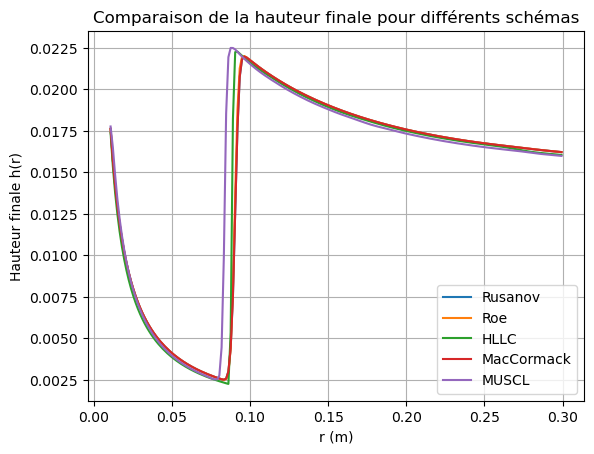

In [1]:

results = run_simulation_offline(dt, t_max, epsilon)
time_array = results['time']

rus_sol   = results['rus_data']
roe_sol   = results['roe_data']
hllc_sol  = results['hllc_data']
macc_sol  = results['macc_data']
muscl_sol = results['muscl_data']

diff_rus_array = results['diff_rus']

h_fin_rus   = rus_sol[-1][0,:]
h_fin_roe   = roe_sol[-1][0,:]
h_fin_hllc  = hllc_sol[-1][0,:]
h_fin_macc  = macc_sol[-1][0,:]
h_fin_muscl = muscl_sol[-1][0,:]

plt.figure()
plt.plot(r, h_fin_rus,   label='Rusanov')
plt.plot(r, h_fin_roe,   label='Roe')
plt.plot(r, h_fin_hllc,  label='HLLC')
plt.plot(r, h_fin_macc,  label='MacCormack')
plt.plot(r, h_fin_muscl, label='MUSCL')
plt.xlabel('r (m)')
plt.ylabel('Hauteur finale h(r)')
plt.title('Comparaison de la hauteur finale pour différents schémas')
plt.legend()
plt.grid()
plt.show()

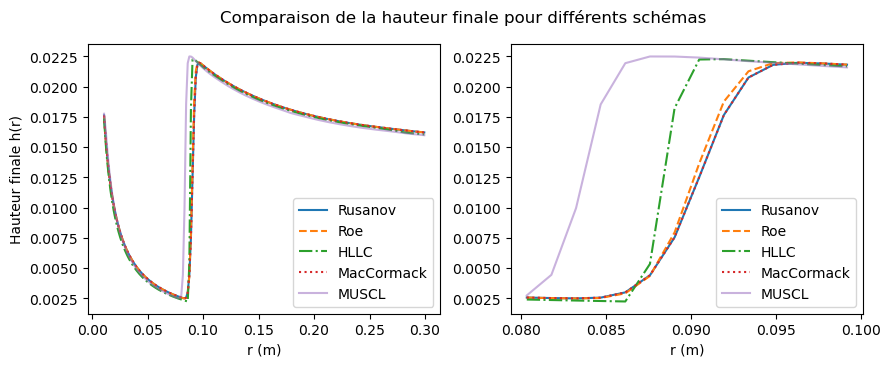

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

axs[0].plot(r, h_fin_rus,   label='Rusanov')
axs[0].plot(r, h_fin_roe,   label='Roe', linestyle='--')
axs[0].plot(r, h_fin_hllc,  label='HLLC', linestyle='-.')
axs[0].plot(r, h_fin_macc,  label='MacCormack', linestyle=':')
axs[0].plot(r, h_fin_muscl, label='MUSCL', linestyle='-', alpha=0.5)
axs[0].set_xlabel('r (m)')
axs[0].set_ylabel('Hauteur finale h(r)')
#axs[0].set_title('Comparaison de la hauteur finale pour différents schémas')
axs[0].legend()


range_1 = int((0.08-0.01)/dr)
range_2 = int((0.1-0.01)/dr)

axs[1].plot(r[range_1: range_2], h_fin_rus[range_1: range_2],   label='Rusanov')
axs[1].plot(r[range_1: range_2], h_fin_roe[range_1: range_2],   label='Roe', linestyle='--')
axs[1].plot(r[range_1: range_2], h_fin_hllc[range_1: range_2],  label='HLLC', linestyle='-.')
axs[1].plot(r[range_1: range_2], h_fin_macc[range_1: range_2],  label='MacCormack', linestyle=':')
axs[1].plot(r[range_1: range_2], h_fin_muscl[range_1: range_2], label='MUSCL', alpha=0.5)
axs[1].set_xlabel('r (m)')
#axs[1].set_ylabel('Hauteur finale h(r)')
#axs[1].set_title('Comparaison de la hauteur finale pour différents schémas')
axs[1].legend()

fig.suptitle('Comparaison de la hauteur finale pour différents schémas')

fig.savefig("Comparaison_hauteur_finale.svg")

On regarde avec les nombres de Froude.

In [22]:
hu_fin_roe= roe_sol[-1][1,:]

Fr_Roe = np.zeros_like(h_fin_roe)
mask = (h_fin_roe>1e-10)
Fr_Roe = np.abs(hu_fin_roe[mask]/h_fin_roe[mask]) / np.sqrt(g*h_fin_roe[mask])

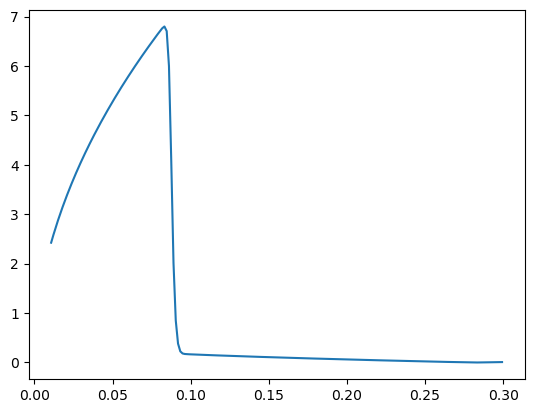

In [23]:
plt.plot(r, Fr_Roe)

In [55]:
i = int((0.085-0.01)/dr)

h_f = h_fin_roe[i]*(np.sqrt(1+8*Fr_Roe[i]**2)-1)/2
print(h_f)

0.022863707774778395


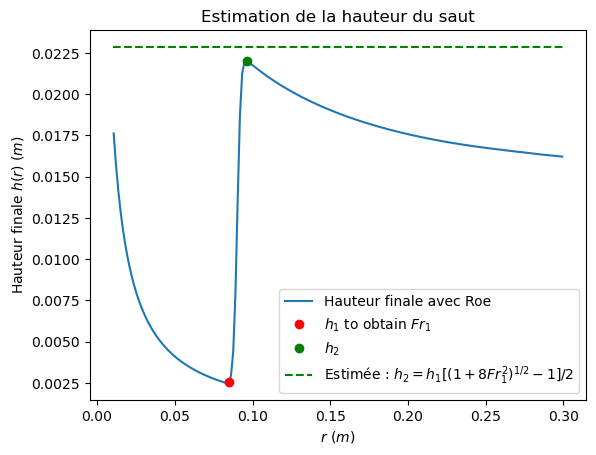

In [63]:
plt.plot(r, h_fin_roe, label='Hauteur finale avec Roe')
plt.plot([r[i]], [h_fin_roe[i]], 'ro', label=r'$h_1$ to obtain $Fr_1$')
plt.plot([r[np.argmax(h_fin_roe)]], [np.max(h_fin_roe)], 'go', label=r'$h_2$')
plt.plot([0.01, 0.3], [h_f, h_f], '--', label=r'Estimée : $h_2 = h_1 [(1+8Fr_1^2)^{1/2} - 1]/2$', color='green')
plt.xlabel(r'$r$ ($m$)')
plt.ylabel(r'Hauteur finale $h(r)$ ($m$)')
plt.legend()

plt.title("Estimation de la hauteur du saut")
plt.savefig("Estimation_hauteur_saut.svg")